In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
from torchsummary import summary
from torch.utils.data import DataLoader
from PIL import Image
from dataloader import WHU
from utils import dataset_split
from torchvision import transforms
from model import Segmentor
from utils import  plot
from engine import train_val , test , matching

Splitting dataset into train/test/val --> 280/60/60

In [2]:
train_dir = "../Datasets/WHU-Bldg/dataset/train"
val_dir = "../Datasets/WHU-Bldg/dataset/val"
test_dir = "../Datasets/WHU-Bldg/dataset/test"

Checking the effect of downsizing the images

In [ ]:
index = 4
# Open the original image
image = Image.open(os.path.join(train_dir,f"Images/{index}.png")).convert("RGB")

trans = transforms.Compose([
    transforms.Resize((512, 512))  # Use a smaller size to see the downsizing effect
])

# Apply the transformation
image_2 = Image.open(os.path.join(train_dir,f"Masks/{index}.png"))

image = np.array(image)
image_2 = np.array(image_2)


fig , axs = plt.subplots(nrows= 1 , ncols=2 , figsize = (10,10))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].set_axis_off()
axs[1].imshow(image_2 , cmap = 'viridis')
axs[1].set_title("Mask")
axs[1].set_axis_off()
plt.show()

In [3]:
#HYPERPARAMETERS
BATCH_SIZE = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.01
scheduler = "exponential"
epochs = 50

In [4]:
train_dataset = WHU(parent_dir=train_dir)

val_dataset = WHU(parent_dir=val_dir)

test_dataset = WHU(parent_dir=test_dir)

In [5]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True , drop_last = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False , drop_last=True)
len(train_loader) , len(test_loader) , len(val_loader)

(1184, 604, 259)

In [ ]:
val_iter = iter(test_loader)
batch = next(val_iter)
images , masks = batch

In [ ]:
index = 7 # sample number from the batch
mask = masks[index].squeeze()
image = images[index]
image.shape

In [ ]:
mask = mask.unsqueeze(dim = 0).permute(1 , 2 , 0)
mask = mask.numpy()
img = image.permute(1 , 2 , 0)
img = img.numpy()

fig , axs = plt.subplots(nrows = 1 , ncols = 2 , figsize = (10 , 10))
axs[0].imshow(img)
axs[0].set_title("Original Image")
axs[0].axis('off')
axs[1].imshow(mask)
axs[1].set_title("Mask")
axs[1].axis('off')
plt.show()


In [6]:
model = Segmentor().to(device)
summary(model , input_size=( 3 , 512 , 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 510, 510]           1,792
              ReLU-2         [-1, 64, 510, 510]               0
       BatchNorm2d-3         [-1, 64, 510, 510]             128
            Conv2d-4         [-1, 96, 508, 508]          55,392
              ReLU-5         [-1, 96, 508, 508]               0
       BatchNorm2d-6         [-1, 96, 508, 508]             192
         MaxPool2d-7         [-1, 96, 254, 254]               0
            Conv2d-8        [-1, 128, 252, 252]         110,720
              ReLU-9        [-1, 128, 252, 252]               0
      BatchNorm2d-10        [-1, 128, 252, 252]             256
           Conv2d-11        [-1, 256, 250, 250]         295,168
             ReLU-12        [-1, 256, 250, 250]               0
      BatchNorm2d-13        [-1, 256, 250, 250]             512
        MaxPool2d-14        [-1, 256, 1

Training

In [ ]:
train_loss , val_loss  = train_val(model = model , 
                                                        train_loader = train_loader, 
                                                        val_loader = val_loader, 
                                                        epochs = epochs, 
                                                        lr = lr, 
                                                        device = device , 
                                                        lr_schedule=scheduler , 
                                                        out_dir = "weights/resume/best_checkpoint.pth" ,
                                                        neptune_config="../neptune.json" , 
                                                        )

In [7]:
test_results = test(model , test_loader=test_loader , checkpoint = "weights/best_checkpoint.pth" , 
                             device = device,
                             output_dir= "results" , 
                             name = "results_2")

Testing progress: 604it [08:53,  1.13it/s]

Test Loss -------------> 0.09326924108984935
Test IoU@0.3 -------------> 0.7201619837525616
Test IoU@0.5 -------------> 0.7201619837525616
Test IoU@0.75 -------------> 0.7201619837525616
Test Precision Score -------------> 0.839462115100568
Test Recall Score -------------> 0.8356044074704245
Test F1 Score -------------> 0.8317446793076465
Test Dice Loss -------------> -0.5394424705315899


In [ ]:
final_iou , final_f1 , final_tp_iou = matching(model , loader = test_loader , checkpoint="weights/best_checkpoint.pth" , device = device)

outputs shape torch.Size([4, 1, 512, 512])


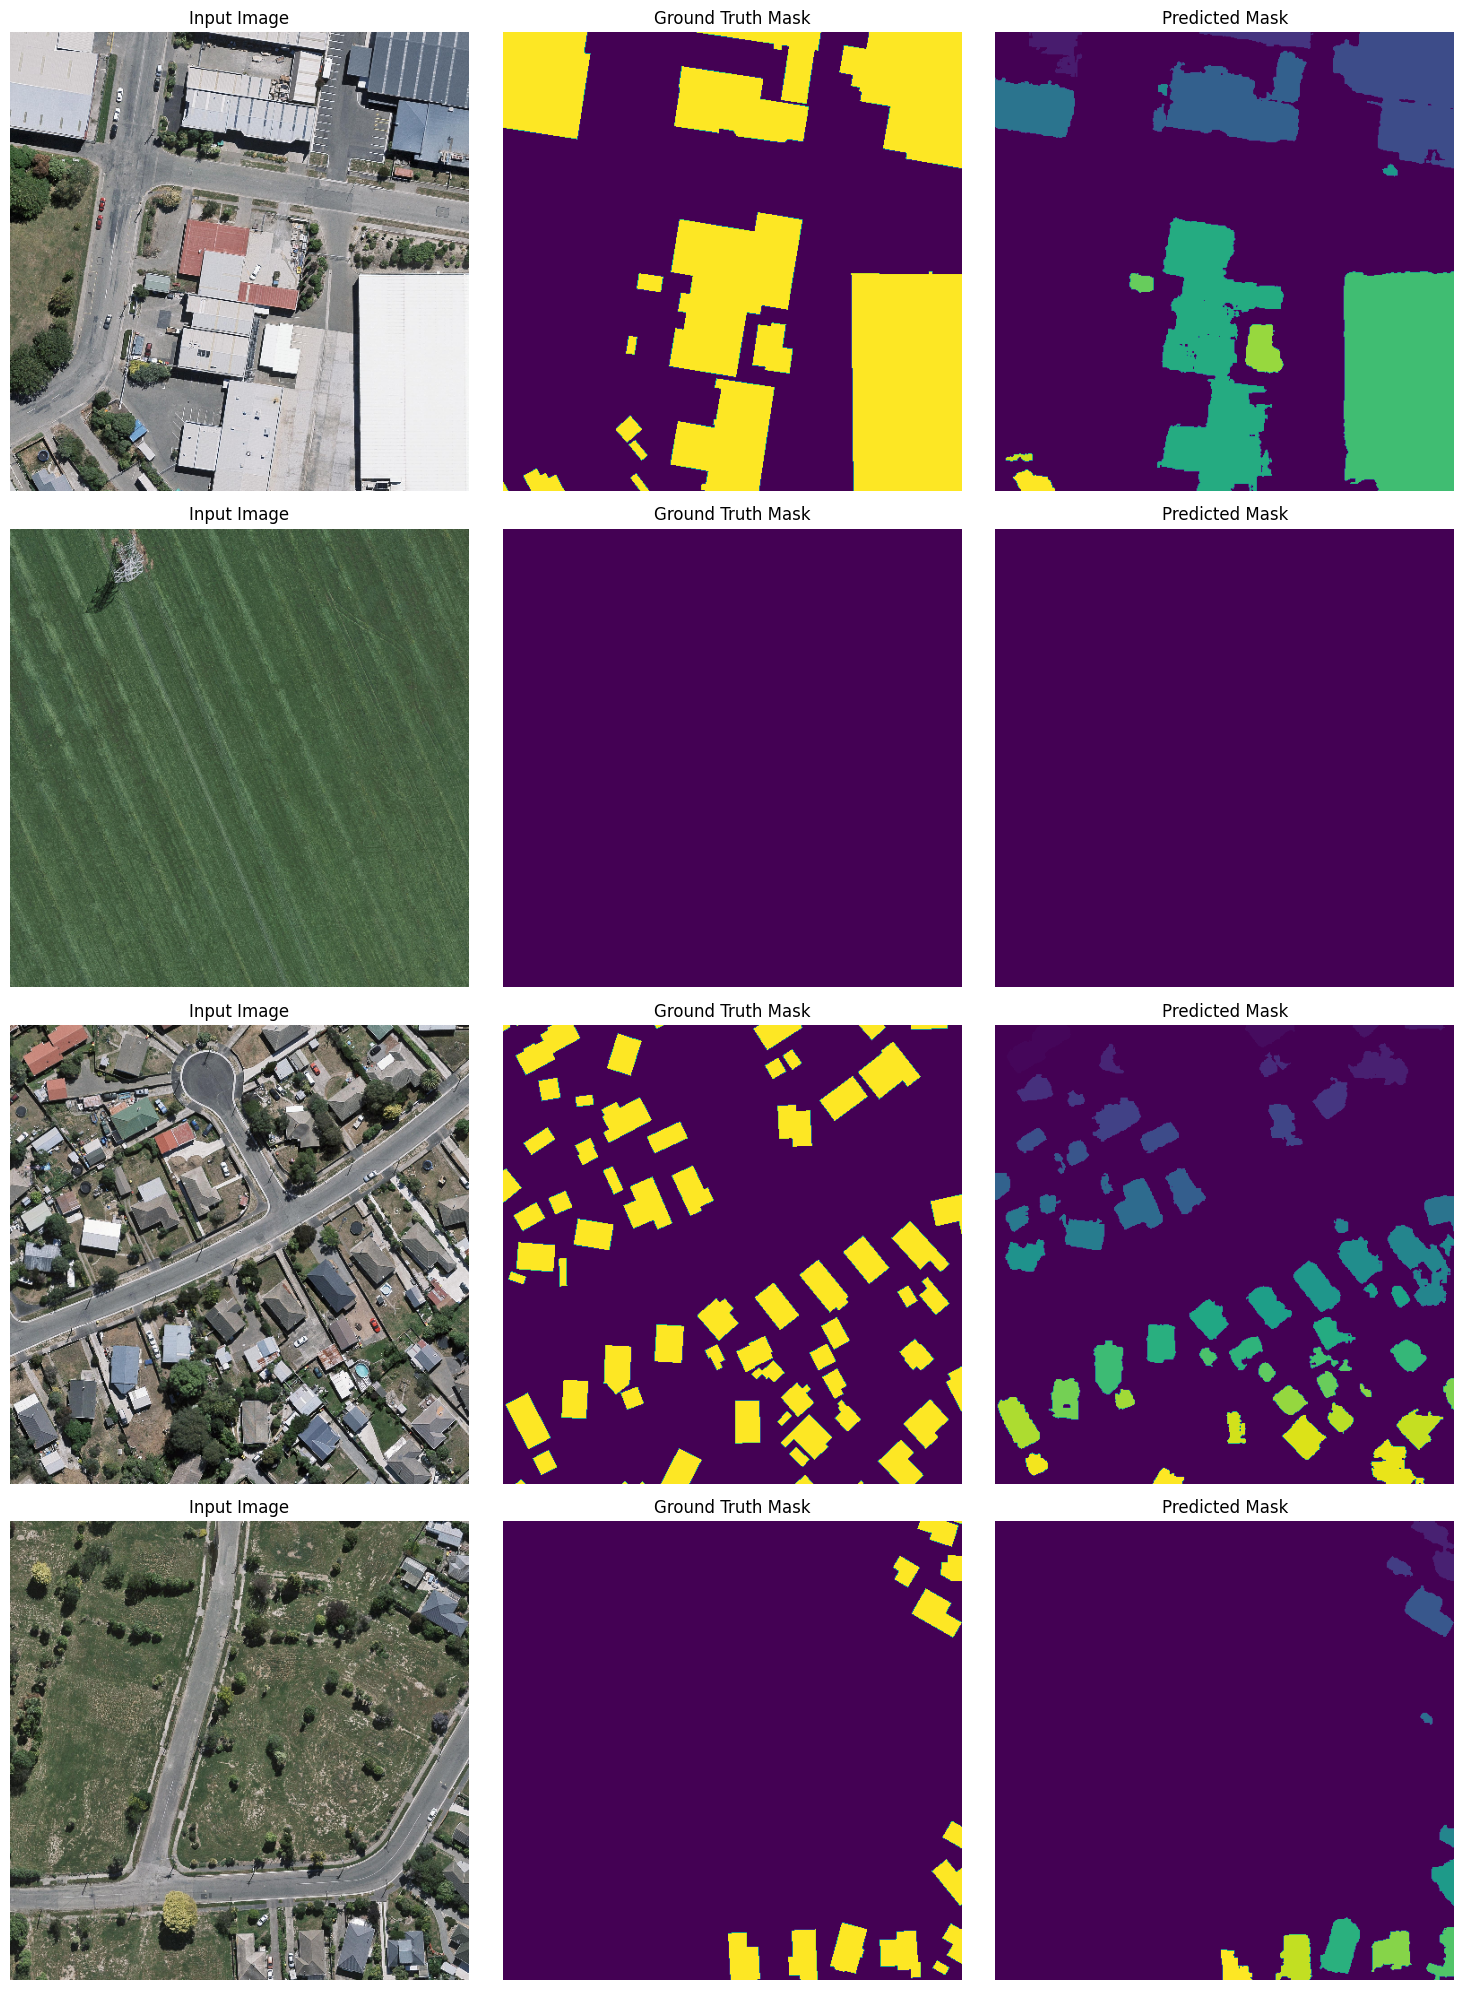

In [10]:
test_iter = iter(test_loader)
batch = next(test_iter)
images , masks = batch
#2
batch = next(test_iter)
images , masks = batch
#3
batch = next(test_iter)
images , masks = batch

#images --> [batch, 3 , 512 , 512]    / masks --> [batch , 1 , 512 , 512]
# pred_masks --> outputs --> [batch , 1 , 512 , 512]
plot(model = model , images = images , gt_masks = masks , checkpoint="weights/best_checkpoint.pth", device = device)